In [1]:
import os
import sys
import shutil
import argparse
import math
import IPython 
from PIL import Image
from enum import Enum
from typing import Callable, List, Optional, Tuple, Union
from functools import partial

import torch
import torch.nn as nn
import torchvision
from torchvision.datasets import VisionDataset
from torchvision.transforms import transforms
import numpy as np
import pandas as pd
import skimage
from scipy import sparse
import matplotlib.pyplot as plt 
import torchxrayvision as xrv
import nibabel as nib

from fvcore.common.checkpoint import Checkpointer, PeriodicCheckpointer
import dinov2.distributed as distributed
from dinov2.models.unet import UNet
from dinov2.data import SamplerType, make_data_loader, make_dataset
from dinov2.data.datasets import NIHChestXray, MC, Shenzhen, SARSCoV2CT
from dinov2.data.datasets.medical_dataset import MedicalVisionDataset
from dinov2.data.loaders import make_data_loader
from dinov2.data.transforms import (make_segmentation_train_transforms, make_classification_eval_transform, make_segmentation_eval_transforms,
                                    make_classification_train_transform)
from dinov2.eval.setup import setup_and_build_model
from dinov2.eval.utils import (is_zero_matrix, ModelWithIntermediateLayers, ModelWithNormalize, evaluate, extract_features, collate_fn_3d,
                               make_datasets)
from dinov2.eval.classification.utils import LinearClassifier, create_linear_input, setup_linear_classifiers, AllClassifiers
from dinov2.eval.metrics import build_segmentation_metrics
from dinov2.eval.segmentation.utils import LinearDecoder, setup_decoders
from dinov2.utils import show_image_from_tensor

In [2]:
args = argparse.Namespace(config_file='dinov2/configs/eval/vits14_pretrain.yaml', pretrained_weights='models/dinov2_vits14_pretrain.pth', output_dir='results/NIH/dinov2_vits14/knn', opts=[], train_dataset_str='NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH', val_dataset_str='NIHChestXray:split=VAL:root=/mnt/d/data/NIH', test_dataset_str='NIHChestXray:split=TEST:root=/mnt/d/data/NIH', nb_knn=[5, 20, 50, 100, 200], temperature=0.07, gather_on_cpu=False, batch_size=8, n_per_class_list=[-1], n_tries=1, ngpus=1, nodes=1, timeout=2800, partition='learnlab', use_volta32=False, comment='', exclude='')
model, autocast_dtype = setup_and_build_model(args)
autocast_ctx = partial(torch.cuda.amp.autocast, enabled=True, dtype=autocast_dtype)
feature_model = ModelWithIntermediateLayers(model, 1, autocast_ctx, is_3d=True)
# model = ModelWithNormalize(model)

I20230921 11:42:15 22157 dinov2 config.py:60] git:
  sha: c19d50789976d4bd62b2551d3b48f90fb84f81d2, status: has uncommitted changes, branch: main

I20230921 11:42:15 22157 dinov2 config.py:61] batch_size: 8
comment: 
config_file: dinov2/configs/eval/vits14_pretrain.yaml
exclude: 
gather_on_cpu: False
n_per_class_list: [-1]
n_tries: 1
nb_knn: [5, 20, 50, 100, 200]
ngpus: 1
nodes: 1
opts: ['train.output_dir=/mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn']
output_dir: /mnt/c/Users/user/Desktop/dinov2/results/NIH/dinov2_vits14/knn
partition: learnlab
pretrained_weights: models/dinov2_vits14_pretrain.pth
temperature: 0.07
test_dataset_str: NIHChestXray:split=TEST:root=/mnt/d/data/NIH
timeout: 2800
train_dataset_str: NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH
use_volta32: False
val_dataset_str: NIHChestXray:split=VAL:root=/mnt/d/data/NIH
I20230921 11:42:15 22157 dinov2 config.py:27] sqrt scaling learning rate; base: 0.004, new: 0.001
I20230921 11:42:15 22157 dinov2 config.

In [3]:
class _Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

    @property
    def length(self) -> int:
        split_lengths = {
            _Split.TRAIN: 15,
            _Split.VAL: 15,
            _Split.TEST: 20,
        }
        return split_lengths[self]

class BTCV(MedicalVisionDataset):
    Split = _Split

    def __init__(
        self,
        *,
        split: "Shenzhen.Split",
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(split, root, transforms, transform, target_transform)

        self._image_path = self._split_dir + os.sep + "img"
        self.images = os.listdir(self._image_path)

        if self._split != _Split.TEST:
            self._masks_path = self._split_dir + os.sep + "label"
    
        self.class_id_mapping = {    
            0: "background",
            1: "spleen",
            2: "rkid",
            3: "lkid",
            4: "gall",
            5: "eso",
            6: "liver",
            7: "sto",
            8: "aorta",
            9: "IVC",
            10: "veins",
            11: "pancreas",
            12: "rad",
            13: "lad"
        }
        self.class_names = list(self.class_id_mapping.keys())

    def _check_size(self):
        num_of_images = len(os.listdir(self._split_dir + os.sep + "img"))
        print(f"{self._split.length - num_of_images} scans are missing from {self._split.value.upper()} set")

    def get_num_classes(self) -> int:
        return len(self.class_names)

    def is_3d(self) -> bool:
        return True

    def get_image_data(self, index: int) -> np.ndarray:
        image_folder_path = self._image_path + os.sep + self.images[index]
        image_path = image_folder_path + os.sep + os.listdir(image_folder_path)[0]  

        image = nib.load(image_path).get_fdata()
        image = np.stack((image,)*3, axis=0)
        print(image.shape)
        image = torch.from_numpy(image).permute(3, 0, 1, 2).float()

        return image
    
    # def get_target(self, index: int) -> np.ndarray:


    #     return target
    
    def __len__(self) -> int:
        return len(self.images)

    def __getitem__(self, index: int):
        image = self.get_image_data(index)
        target = self.get_target(index)

        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        if self.transform is not None:
            np.random.seed(seed), torch.manual_seed(seed) 
            image = self.transform(image)

        if self.target_transform is not None:
            np.random.seed(seed), torch.manual_seed(seed) 
            target = self.target_transform(target)

        # Remove channel dim in target
        target = target.squeeze()

        return image, target

In [70]:
d = BTCV(root="/mnt/z/data/Abdomen/RawData", split=_Split.TRAIN)

0 scans are missing from TRAIN set


In [71]:
d.get_image_data(8).shape

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


I20230920 17:53:55 373 nibabel.global batteryrunners.py:268] pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1
(3, 512, 512, 89)


torch.Size([89, 3, 512, 512])

In [19]:
data_dir = "/mnt/z/data/Abdomen/RawData/Training/img"


imgs = os.listdir(data_dir)
one_path = data_dir + os.sep + imgs[1]
one = os.listdir(one_path)

In [20]:
image = nib.load(one_path + os.sep + one[0])

pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


I20230920 16:59:24 373 nibabel.global batteryrunners.py:268] pixdim[0] (qfac) should be 1 (default) or -1; setting qfac to 1


In [21]:
array = image.get_fdata()

In [22]:
array.shape

(512, 512, 139)

In [3]:
train_dataset_str = args.train_dataset_str
val_dataset_str = args.val_dataset_str
batch_size = args.batch_size
gather_on_cpu = args.gather_on_cpu
num_workers = 1

In [ ]:
class _Split(Enum):
    TRAIN = "train"
    VAL = "val"
    TEST = "test"

    @property
    def length(self) -> int:
        split_lengths = {
            _Split.TRAIN: 90,
            _Split.VAL: 50,
            _Split.TEST: 70,
        }
        return split_lengths[self]

class SARSCoV2CT(MedicalVisionDataset):
    Split = _Split

    def __init__(
        self,
        *,
        split: "SARSCoV2CT.Split",
        root: str,
        transforms: Optional[Callable] = None,
        transform: Optional[Callable] = None,
        target_transform: Optional[Callable] = None,
    ) -> None:
        super().__init__(split, root, transforms, transform, target_transform)

        self.class_names = [
            "Negative",
            "Positive"
        ]
        
    @property
    def split(self) -> "SARSCoV2CT.Split":
        return self._split

    def get_length(self) -> int:
        return self.__len__()

    def get_num_classes(self) -> int:
        return 2
    
    def is_3d(self) -> bool:
        return True
    
    def is_multilabel(self) -> bool:
        return False

    def get_image_data(self, index: int) -> np.ndarray:
        scans_path = self._split_dir + os.sep + self.images[index]
        scans = os.listdir(scans_path)
        scans = [".".join(scan.split(".")[:-1]) for scan in scans]
        
        if scans[0].isnumeric():
            scans = [int(scan) for scan in scans]
            scans.sort()

        for i, scan in enumerate(scans):
            
            scan = skimage.io.imread(scans_path + os.sep + str(scan) + ".png")
            scan = scan[:, :, :3]
            scan = torch.from_numpy(scan).permute(2, 0, 1).float()

            scans[i] = scan 

        return scans
    
    def get_target(self, index: int) -> int:
        return int(int(self.images[index]) <= 79) # IDs 0-79 are positive
    
    def __len__(self) -> int:
        return len(self.images)
    
    def __getitem__(self, index: int):
        images = self.get_image_data(index)
        target = self.get_target(index)

        seed = np.random.randint(2147483647) # make a seed with numpy generator 
        if self.transforms is not None:
            for i in range(len(images)):
                np.random.seed(seed), torch.manual_seed(seed) 
                images[i] = self.transform(images[i])
            images = torch.stack(images, dim=0)

        return images, target

In [ ]:
a, l = make_segmentation_train_transforms(resize_size=224)

In [41]:
transform = target_transform = make_classification_train_transform()
dataset = SARSCoV2CT(split=SARSCoV2CT.Split.TRAIN,
                root="/mnt/z/data/SARS-CoV-2-CT",
                transform=a)

NameError: name 'a' is not defined

In [ ]:
for i, t in dataset:
    i.cuda()
    show_image_from_tensor(i[0])
    show_image_from_tensor(i[1])
    show_image_from_tensor(i[2])
    show_image_from_tensor(i[3])

In [ ]:
transform(torch.concat(i))

In [37]:
train_data_loader = make_data_loader(
    dataset=dataset,
    collate_fn=collate_fn_3d,
    batch_size=4,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=None,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

NameError: name 'dataset' is not defined

In [ ]:
class LinearClassifier(nn.Module):
    """Linear layer to train on top of frozen features"""

    def __init__(self, out_dim, use_n_blocks, use_avgpool, num_classes=1000, is_3d=False):
        super().__init__()
        self.out_dim = out_dim
        self.use_n_blocks = use_n_blocks
        self.use_avgpool = use_avgpool
        self.num_classes = num_classes
        self.linear = nn.Linear(out_dim, num_classes)
        self.linear.weight.data.normal_(mean=0.0, std=0.01)
        self.linear.bias.data.zero_()
        self.is_3d = is_3d

    def forward_3d(self, inputs):
        outputs_per_batch = []
        for batch in inputs:
            outputs_per_batch.append(self.forward_(batch))
        outputs = torch.stack(outputs_per_batch).squeeze()
        return outputs
    
    def forward_(self, inputs):
        output = torch.stack( # If 3D, take average of all slices.
            [create_linear_input(image, self.use_n_blocks, self.use_avgpool) for image in inputs]
            ).mean(dim=0)
        return output.squeeze()
    
    def forward(self, images):
        if self.is_3d: output = self.forward_3d(images)
        else: output = self.forward_(images)

        return self.linear(output).squeeze()

lc = LinearClassifier(384, 1, False, 1, is_3d=True).cuda()

In [ ]:
sample_output = feature_model.forward_(dataset[0][0][0].unsqueeze(0).cuda())

In [ ]:
def setup_linear_classifiers(sample_output, n_last_blocks_list, learning_rates, avgpools=[True, False], num_classes=14, is_3d=False):
    """
    Sets up the multiple linear classifiers with different hyperparameters to test out the most optimal one 
    """
    linear_classifiers_dict = nn.ModuleDict()
    optim_param_groups = []
    for n in n_last_blocks_list:
        for avgpool in avgpools:
            for _lr in learning_rates:
                # lr = scale_lr(_lr, batch_size)
                lr = _lr
                out_dim = create_linear_input(sample_output, use_n_blocks=n, use_avgpool=avgpool).shape[1]
                linear_classifier = LinearClassifier(
                    out_dim, use_n_blocks=n, use_avgpool=avgpool, num_classes=num_classes, is_3d=is_3d
                )
                linear_classifier = linear_classifier.cuda()
                linear_classifiers_dict[
                    f"linear:blocks={n}:avgpool={avgpool}:lr={lr:.10f}".replace(".", "_")
                ] = linear_classifier
                optim_param_groups.append({"params": linear_classifier.parameters(), "lr": lr})

    linear_classifiers = AllClassifiers(linear_classifiers_dict)
    if distributed.is_enabled():
        linear_classifiers = nn.parallel.DistributedDataParallel(linear_classifiers)

    return linear_classifiers, optim_param_groups

In [ ]:
linear_classifiers, optim_param_groups = setup_linear_classifiers(
    sample_output=sample_output,
    n_last_blocks_list=[1, 4],
    learning_rates=[1e-2, 1e-4],
    avgpools=[False, True],
    num_classes=1,
    is_3d=True
)

In [ ]:
class AllClassifiers(nn.Module):
    def __init__(self, classifiers_dict):
        super().__init__()
        self.classifiers_dict = nn.ModuleDict()
        self.classifiers_dict.update(classifiers_dict)

    def forward(self, inputs):
        print(inputs)
        print("1")
        return {k: v.forward(inputs) for k, v in self.classifiers_dict.items()}

    def __len__(self):
        return len(self.classifiers_dict)

In [ ]:
z = 0
f = 0
for i, t in train_data_loader:
    i = i.cuda()
    t = t.cuda()

    features = feature_model(i)  # batch then slices
    # output = lc(features)
    output = linear_classifiers(features)
    break

    # outputs = [
    #     list(self.all_classifiers_forward(batch_feature).values()) for batch_feature in inputs
    #     ]
    # classifier_outputs = [torch.stack(output).squeeze() for output in outputs] # stack across classifiers
    # outputs = torch.stack(classifier_outputs, dim=1) # stack across batch
    # classifiers = list(self.classifiers_dict.keys())
    # outputs = { # output for every classifer
    #     classifiers[i]: output 
    #     for i, output in enumerate(outputs)
    # }
    # return outputs
    break
    outputs = [lc(batch_feature) for batch_feature in batch_features]
    outputs = torch.stack(outputs, dim=0).squeeze(1)
    print(outputs)
    break
    if z == 5:
        break
    z+=1

In [11]:
class RescaleImage:
    def __call__(self, image):
        if isinstance(image, np.ndarray):
            # Convert to tensor
            image = torch.from_numpy(image)
        elif torch.is_tensor(image):
            pass
        else:
            raise TypeError("Input should be of type numpy.ndarray or torch.Tensor")

        # Rescale the tensor to [0, 1]
        min_val = image.min()
        max_val = image.max()
        return (image - min_val) / (max_val - min_val)


class MaybeToTensor(transforms.PILToTensor):
    """
    Convert a ``PIL Image`` or ``numpy.ndarray`` to tensor, or keep as is if already a tensor.
    """

    def __call__(self, pic):
        """
        Args:
            pic (PIL Image, numpy.ndarray or torch.tensor): Image to be converted to tensor.
        Returns:
            Tensor: Converted image.
        """
        if isinstance(pic, torch.Tensor):
            return pic
        if isinstance(pic, np.ndarray):
            return torch.from_numpy(pic)
        return super().__call__(pic)

# Use timm's names
IMAGENET_DEFAULT_MEAN = (0.485, 0.456, 0.406)
IMAGENET_DEFAULT_STD = (0.229, 0.224, 0.225)


def make_normalize_transform(
    mean= IMAGENET_DEFAULT_MEAN,
    std  = IMAGENET_DEFAULT_STD,
) -> transforms.Normalize:
    return transforms.Normalize(mean=mean, std=std)


def make_segmentation_train_transforms(
    *,
    resize_size: int = 448,
    vflip_prob: float = 0.5,
    rot_deg: float = 45,
    interpolation=transforms.InterpolationMode.BICUBIC,
    mean= IMAGENET_DEFAULT_MEAN,
    std = IMAGENET_DEFAULT_STD,
) -> transforms.Compose:
    train_transforms_list = [
        transforms.Resize((resize_size, resize_size), interpolation=interpolation)
        ]
    target_transforms_list = [
        transforms.Resize((resize_size, resize_size), interpolation=interpolation)
        ]
    if vflip_prob > 0:
        train_transforms_list.append(transforms.RandomVerticalFlip(vflip_prob))
        target_transforms_list.append(transforms.RandomVerticalFlip(vflip_prob))
    if rot_deg > 0:
        train_transforms_list.append(transforms.RandomRotation(rot_deg))
        target_transforms_list.append(transforms.RandomRotation(rot_deg))

    train_transforms_list.extend([    
        MaybeToTensor(),
        RescaleImage(),
        # make_normalize_transform(mean=mean, std=std),
    ])
    target_transforms_list.append(MaybeToTensor())

    return (transforms.Compose(train_transforms_list),
            transforms.Compose(target_transforms_list))

def make_classification_train_transform(
    *,
    crop_size: int = 224,
    interpolation=transforms.InterpolationMode.BICUBIC,
    hflip_prob: float = 0.5,
    mean = IMAGENET_DEFAULT_MEAN,
    std = IMAGENET_DEFAULT_STD,
):
    transforms_list = [
        transforms.RandomResizedCrop(crop_size, scale=(0.75, 1), interpolation=interpolation),
    ]
    if hflip_prob > 0.0:
        transforms_list.append(transforms.RandomHorizontalFlip(hflip_prob))
    transforms_list.extend(
        [
            MaybeToTensor(),
            RescaleImage(),
            # make_normalize_transform(mean=mean, std=std),
        ]
    )
    return transforms.Compose(transforms_list)

In [12]:
# train_image_transform, train_target_transform = make_segmentation_train_transforms()
# eval_image_transform, eval_target_transform  = make_segmentation_eval_transforms()
train_image_transform = make_classification_train_transform()
eval_image_transform = make_classification_eval_transform()
train_target_transform = eval_target_transform = None

train_dataset, val_dataset, test_dataset = make_datasets(train_dataset_str=args.train_dataset_str, val_dataset_str=args.val_dataset_str,
                                                        test_dataset_str=args.test_dataset_str, train_transform=train_image_transform,
                                                        eval_transform=eval_image_transform, train_target_transform=train_target_transform,
                                                        eval_target_transform=eval_target_transform)

sampler_type = SamplerType.INFINITE

train_data_loader = make_data_loader(
    dataset=train_dataset,
    batch_size=8,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

val_data_loader = make_data_loader(
    dataset=val_dataset,
    batch_size=4,
    num_workers=1,
    shuffle=True,
    seed=0,
    sampler_type=sampler_type,
    sampler_advance=1,
    drop_last=False,
    persistent_workers=True,
)

I20230921 11:44:08 22157 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=TRAIN:root=/mnt/d/data/NIH"
I20230921 11:44:08 22157 dinov2 medical_dataset.py:36] 0 scans are missing from TRAIN set
I20230921 11:44:09 22157 dinov2 loaders.py:99] # of dataset samples: 76,522
I20230921 11:44:09 22157 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=VAL:root=/mnt/d/data/NIH"
I20230921 11:44:09 22157 dinov2 medical_dataset.py:36] 0 scans are missing from VAL set
I20230921 11:44:09 22157 dinov2 loaders.py:99] # of dataset samples: 10,002
I20230921 11:44:09 22157 dinov2 loaders.py:94] using dataset: "NIHChestXray:split=TEST:root=/mnt/d/data/NIH"
I20230921 11:44:09 22157 dinov2 medical_dataset.py:36] 0 scans are missing from TEST set
I20230921 11:44:09 22157 dinov2 loaders.py:99] # of dataset samples: 25,596
I20230921 11:44:09 22157 dinov2 loaders.py:122] sampler: infinite
I20230921 11:44:09 22157 dinov2 loaders.py:216] using PyTorch data loader
I20230921 11:44:09 22157 dinov2 loader

torch.Size([3, 224, 224])
tensor(1., dtype=torch.float16)
tensor(0., dtype=torch.float16)


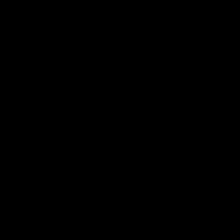

AttributeError: 'numpy.ndarray' object has no attribute 'unsqueeze'

In [13]:
for i, t in train_dataset:
    i.cuda() 
    # t.cuda()
    
    print(i)

    print(i.shape)

    print(i.max())
    print(i.min())

    show_image_from_tensor(i)
    show_image_from_tensor(t.unsqueeze(0) * 100)
    break

In [ ]:
for i, t in train_data_loader:
    i = i.cuda()
    i = feature_model(i)
    print(len(i))
    print(len(i[0]))
    print(len(i[0][0]))
    print(len(i[0][0][0]))
    print(len(i[0][0][0][0]))
    break

In [ ]:
class LinearDecoder(torch.nn.Module):
    """Linear decoder head"""
    DECODER_TYPE = "linear"

    def __init__(self, in_channels, tokenW=32, tokenH=32, num_classes=3):
        super().__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_classes, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        print(embeddings.shape)
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        print(embeddings.shape)
        embeddings = embeddings.permute(0,3,1,2)
        print(embeddings.shape)

        return self.decoder(embeddings)

In [ ]:
d = LinearDecoder(384, num_classes=2).cuda()

In [ ]:
for i, t in train_dataset:
    i = i.cuda().unsqueeze(0)
    a = model(i)
    b = model.forward_features(i)['x_norm_patchtokens']
    z = d(b)
    print(z.shape)
    break

In [ ]:
concated = torch.utils.data.ConcatDataset([train_dataset, val_dataset])

In [ ]:
len(concated)

In [ ]:
concated.get_num_classes()

In [ ]:
for i, t in concated:
    print(i)

In [ ]:
data_dir = "/mnt/d/data/NIH/"
train_val = pd.read_csv(data_dir + os.sep + "train_val_list.txt", names=["Image Index"])
val_list = [i for i in range(len(train_val)-10_002, len(train_val))]
val_set = train_val.iloc[val_list]
train_set = train_val.drop(val_list)

train_dir = data_dir + os.sep + "train"
val_dir = data_dir + os.sep + "val"
for image in val_set["Image Index"]:
    source = train_dir + os.sep + image
    dest = val_dir + os.sep + image
    shutil.move(source, dest)

val_set.to_csv(data_dir + os.sep + "val_list.txt", index=False, header=False)
train_set.to_csv(data_dir + os.sep + "train_list.txt", index=False, header=False)

In [ ]:
class LinearDecoder(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearDecoder, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.decoder = torch.nn.Conv2d(in_channels, num_labels, (1,1))
        self.decoder.weight.data.normal_(mean=0.0, std=0.01)
        self.decoder.bias.data.zero_()

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.decoder(embeddings)

In [ ]:
decoder = LinearDecoder(384, num_labels=3).cuda()
optimizer = torch.optim.SGD(params=decoder.parameters(), lr=0.0005, momentum=0.9, weight_decay=0)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, 69, eta_min=0)

In [ ]:
class MetricAveraging(Enum):
    MEAN_ACCURACY = "micro"
    MEAN_PER_CLASS_ACCURACY = "macro"
    MULTILABEL_ACCURACY = "macro"
    MULTILABEL_AUROC = "macro"
    MULTILABEL_JACCARD = "macro"
    PER_CLASS_ACCURACY = "none"

    def __str__(self):
        return self.value

metric = build_segmentation_metrics(average_type=MetricAveraging.MULTILABEL_JACCARD,num_labels=3)
metric.cuda()

In [ ]:
i = 0
for image, target in train_data_loader:
    i+=1
    image, target = image.cuda(non_blocking=True), target.cuda(non_blocking=True)
    with torch.no_grad(): 
        features=model.forward_features(image)['x_norm_patchtokens']
    logits = decoder(features)
    logits = torch.nn.functional.interpolate(logits, size=448, mode="bilinear", align_corners=False)
    prediction = logits.argmax(dim=1)

    loss_fct = torch.nn.CrossEntropyLoss()
    loss = loss_fct(logits, target)
    
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()
    scheduler.step()

    metric(prediction, target)
    print(metric.compute())
    print(loss.item())

    # if i % 50 == 0:
    show_image_from_tensor((prediction * 100).cpu())
    show_image_from_tensor((target * 100).cpu())